<h1>Classification of Stellar Objects</h1>

In astronomy, the classification of stars, galaxies, and quasars is fundamental towards the understanding of our own galaxy. Galaxies are large systems of stars (Greshko, 2021), whereas quasars are active galactic nuclei powered by supermassive black holes found at the center of massive galaxies (Bañados et al. 2016). The three can be hard to differentiate solely through observation as they all radiate different wavelengths, hence, astronomers use other spectral characteristics for object identification.

**Predictive Question:** *Is it possible to use Sloan Digital Sky Survey (SDSS) measurements to predict whether a future stellar body of an unknown type is a star, quasar or galaxy?*

The dataset used in our project contains 100,000 observations of space, each of which are classified as a star, galaxy, or quasar, based on their spectral characteristics. Every observation was taken by the SDSS telescope.

**Data Set:** Stellar Classification Dataset - SDSS17 https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17

Variables of our interest in the dataset:

+ u: the ultraviolet filter in the photometric system
+ g: the green filter in the photometric system
+ r: the red filter in the photometric system
+ i: the near infrared filter in the photometric system
+ z: the infrared filter in the photometric system
+ class: the object class (galaxy, star or quasar object)
+ redshift: the redshift value based on the increase in wavelength


In [69]:
#Group project DSCI 100 Group #3

# Testing if github collaboration works

library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

<h3>Preliminary Exploratory Data Analysis</h3>

*The cell below demonstrates reading our data into R and checks for any missing values*

In [70]:
star_data <- read_csv("https://raw.githubusercontent.com/Margokap/DSCI100-group-03/main/star_classification.csv")
## reading data into the notebook

map_df(star_data, ~sum(is.na(.)))

Rows: 100000 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): class
dbl (17): obj_ID, alpha, delta, u, g, r, i, z, run_ID, rerun_ID, cam_col, fi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<h5> I. Tidying of our chosen dataset: </h5>

After some research, we decided to select 7 variables out of the 17, with class acting as the categorical variable to be predicted. In our research, we learned that photometrics measure intensities of different wavelengths and are used by astronomers to study structure and composition of celestial objects (Grier & Rivkin, 2019) whereas redshift is used in distance, velocity, and other calculations. Hence, we decided to keep these. 

In [72]:
star_data_tidy <- select(star_data, u, g, 
                          r, i, z, redshift, class)
## selecting columns after research
star_data_tidy

u,g,r,i,z,redshift,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
23.87882,22.27530,20.39501,19.16573,18.79371,0.6347936,GALAXY
24.77759,22.83188,22.58444,21.16812,21.61427,0.7791360,GALAXY
25.26307,22.66389,20.60976,19.34857,18.94827,0.6441945,GALAXY
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21.16916,19.26997,18.20428,17.69034,17.35221,0.1433656,GALAXY
25.35039,21.63757,19.91386,19.07254,18.62482,0.4550396,GALAXY
22.62171,21.79745,20.60115,20.00959,19.28075,0.5429442,GALAXY


We then decided to name our columns more appropriately, which completed our cleaning of the dataset.

In [73]:
names(star_data_tidy) <- c("UV_filter",
                            "Green_filter",
                            "Red_filter",
                            "Near_Infrared_filter",
                            "Infrared_filter",
                            "Redshift",
                            "Stellar_object")
star_data_tidy

UV_filter,Green_filter,Red_filter,Near_Infrared_filter,Infrared_filter,Redshift,Stellar_object
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
23.87882,22.27530,20.39501,19.16573,18.79371,0.6347936,GALAXY
24.77759,22.83188,22.58444,21.16812,21.61427,0.7791360,GALAXY
25.26307,22.66389,20.60976,19.34857,18.94827,0.6441945,GALAXY
⋮,⋮,⋮,⋮,⋮,⋮,⋮
21.16916,19.26997,18.20428,17.69034,17.35221,0.1433656,GALAXY
25.35039,21.63757,19.91386,19.07254,18.62482,0.4550396,GALAXY
22.62171,21.79745,20.60115,20.00959,19.28075,0.5429442,GALAXY


<h5>II. Summary of Training Data :</h5>

*We then tried to see how our data was distributed between each stellar object, so we visualised it in a bar graph (see Figure 1.0)*

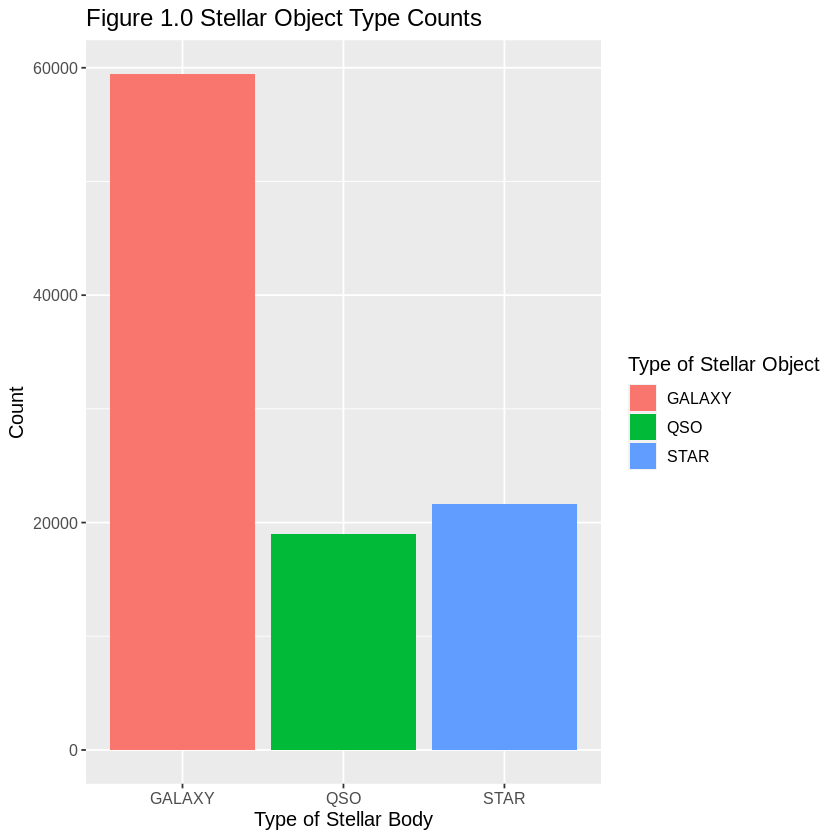

In [52]:
count <- star_data_tidy |> 
         group_by(Stellar_object) |>
         summarize(count = n())

(star_counts_plot <- ggplot(count, aes(x = Stellar_object, y = count, fill = Stellar_object)) + 
   geom_bar(stat = "identity") +
    labs(x = "Type of Stellar Body", fill = "Type of Stellar Object", y = "Count") + 
    theme(text = element_text(size = 12)) +
    ggtitle("Figure 1.0 Stellar Object Type Counts"))

To counter this imbalance, we sampled 1000 values of each type of Stellar Object and resampled again.

In [53]:
#sampling from data to make data balanced
star_data_star <- star_data_tidy |>
                  filter(Stellar_object == "STAR") |>
                  sample_n(1000)

star_data_galaxy <- star_data_tidy |>
                  filter(Stellar_object == "GALAXY") |>
                  sample_n(1000)

star_data_qso <- star_data_tidy |>
                  filter(Stellar_object == "QSO") |>
                  sample_n(1000)

star_data_balanced <- rbind(star_data_qso, star_data_galaxy, star_data_star) |>
                  sample_n(1000)

star_table <- star_data_balanced |>
              group_by(Stellar_object) |>
              summarize(Counts = n())
star_table

Stellar_object,Counts
<chr>,<int>
GALAXY,354
QSO,328
STAR,318


Now, we begin splitting our dataset into testing and training.

In [76]:
star_split <- initial_split(star_data_balanced, prop = 0.75, strata = Stellar_object)
star_training <- training(star_split)
star_testing <- testing(star_split)

star_summary <- star_training |>
              group_by(Stellar_object) |>
              summarize(Mean_ultraviolet_filter = mean(UV_filter), Mean_green_filter = mean(Green_filter),
                        Mean_red_filter = mean(Red_filter), Mean_near_infrared_filter = mean(Near_Infrared_filter), Mean_infrared_filter = mean(Infrared_filter),
                        Mean_infrared_filter = mean(Infrared_filter), Mean_redshift = mean(Redshift), Number_of_stellar_type = n())
star_summary

Stellar_object,Mean_ultraviolet_filter,Mean_green_filter,Mean_red_filter,Mean_near_infrared_filter,Mean_infrared_filter,Mean_redshift,Number_of_stellar_type
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
GALAXY,22.63246,21.03479,19.64755,18.89171,18.47577,4.354830e-01,265
QSO,21.59414,20.95049,20.65001,20.53434,20.32844,1.741841e+00,246
STAR,21.38978,19.79799,19.10666,18.67595,18.44376,-8.737529e-05,238


We will be using these means later on to gauge if there are any significant differences between each variable for all three types. But, first, let's visualise each of our photometrics against redshift.

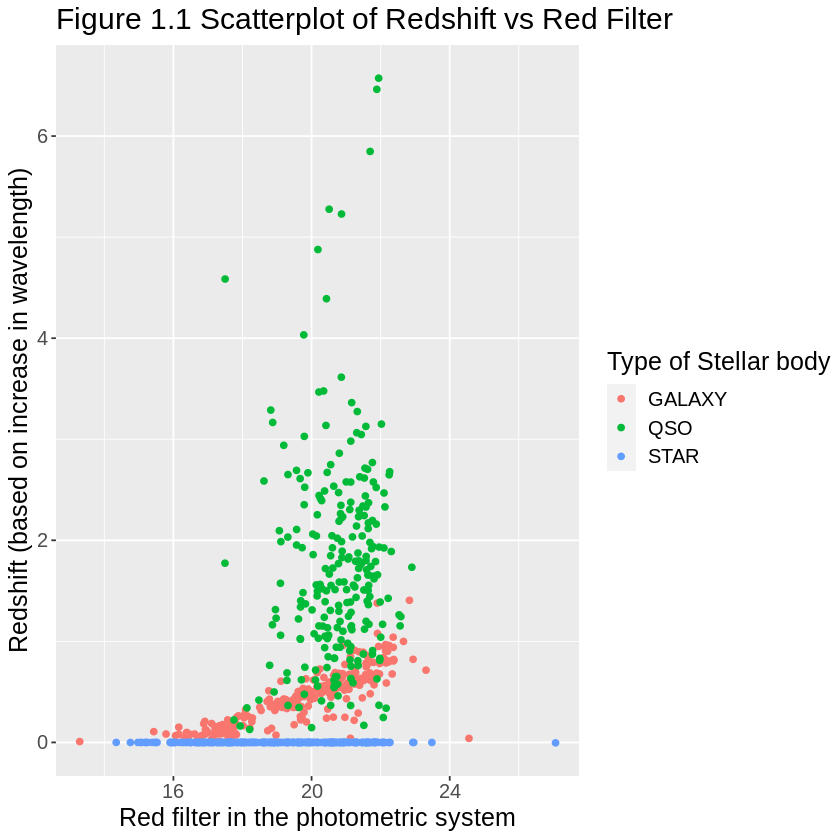

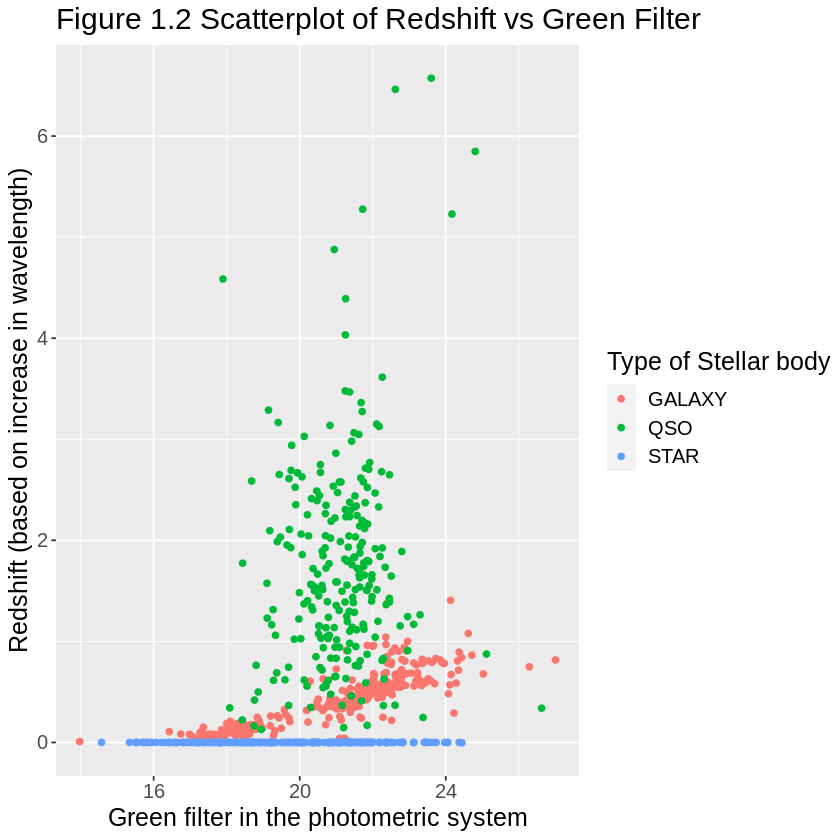

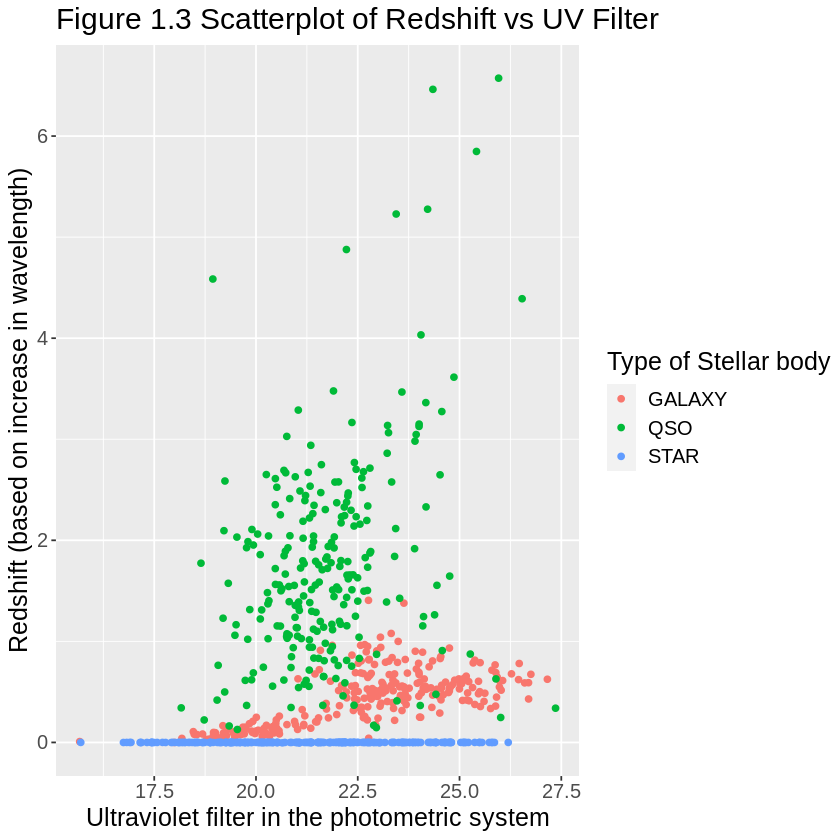

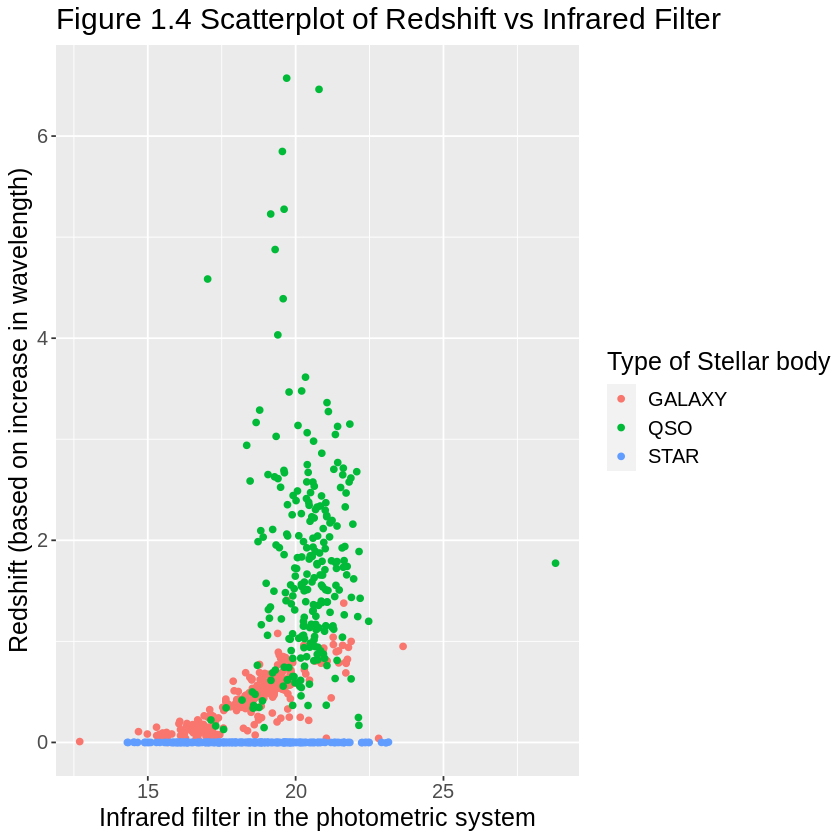

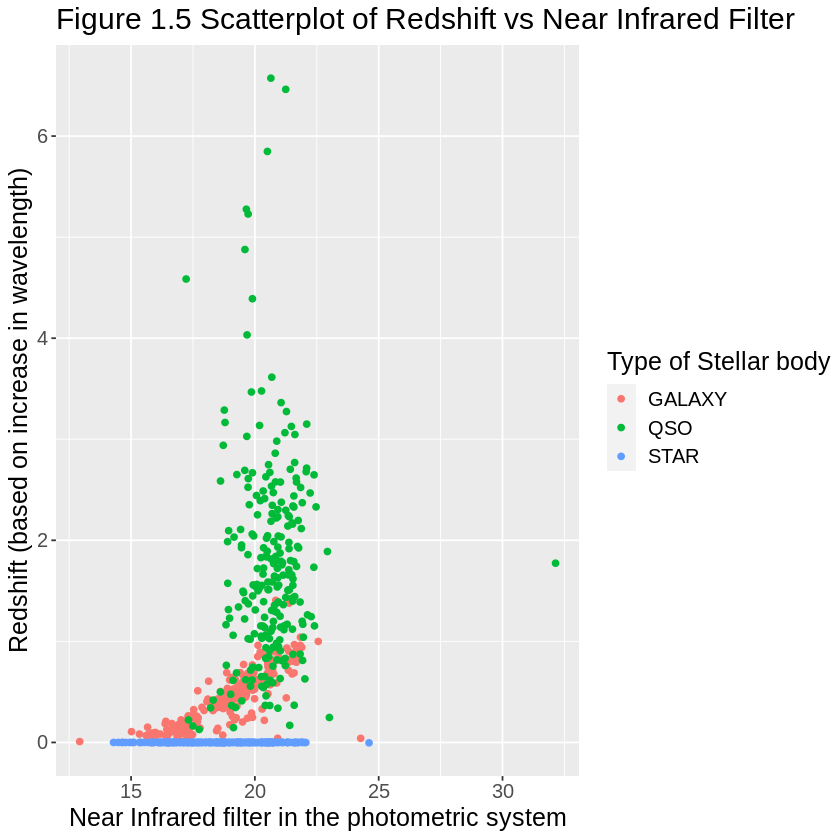

In [68]:
(redshit_vs_red_filter <- ggplot(star_training, aes(y = Redshift, x = Red_filter, color = Stellar_object)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Red filter in the photometric system", color = "Type of Stellar body") +
                              theme(text = element_text(size = 15)) +
                              ggtitle("Figure 1.1 Scatterplot of Redshift vs Red Filter"))
(redshit_vs_green_filter <- ggplot(star_training, aes(y = Redshift, x = Green_filter, color = Stellar_object)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Green filter in the photometric system", color = "Type of Stellar body") +
                              theme(text = element_text(size = 15)) +
                              ggtitle("Figure 1.2 Scatterplot of Redshift vs Green Filter"))
(redshit_vs_uv_filter <- ggplot(star_training, aes(y = Redshift, x = UV_filter, color = Stellar_object)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Ultraviolet filter in the photometric system", color = "Type of Stellar body") +
                              theme(text = element_text(size = 15)) +
                              ggtitle("Figure 1.3 Scatterplot of Redshift vs UV Filter"))
(redshit_vs_infrared_filter <- ggplot(star_training, aes(y = Redshift, x = Infrared_filter, color = Stellar_object)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Infrared filter in the photometric system", color = "Type of Stellar body") +
                              theme(text = element_text(size = 15)) +
                              ggtitle("Figure 1.4 Scatterplot of Redshift vs Infrared Filter"))
(redshit_vs_near_infrared_filter <- ggplot(star_training, aes(y = Redshift, x = Near_Infrared_filter, color = Stellar_object)) +
                              geom_point() +
                              labs(y = "Redshift (based on increase in wavelength)", x = "Near Infrared filter in the photometric system", color = "Type of Stellar body") +
                              theme(text = element_text(size = 15)) +
                              ggtitle("Figure 1.5 Scatterplot of Redshift vs Near Infrared Filter"))

Through our visualisations, we see some interesting patterns which we will explore in our report. 

<h5>Methods:</h5>

The variables we will use to predict the type of stellar body of a new observation are the ultraviolet filter, green filter, red filter, near infrared filter, infrared filter, and redshift. Previous astronomical literature and classification models have demonstrated that many of these factors correlate with stellar body types and may contribute to classifying an astronomical event of type galaxy, quasar or star (Finlay-Freundlich, 1954; Wierzbiński et al. 2021; Simet et al. 2021). In our analysis, we will perform a classification using K-nearest neighbors to predict whether a new observation is a galaxy, quasar or star. Prior to the preprocessing of our training data, we will standardize (i.e. scale and center) our training data to prevent the scales of the predictors from unevenly impacting our model. We will also be visualizing our data by seeing how that new observation fits with the current dataset to see if our KNN prediction seems accurate.

<h5>Expected outcomes and significance:</h5>

We expect to find an accurate, and runtime-efficient classification model which predicts whether a new observation detected using SDSS is a star, galaxy or quasar using its spectral properties.

With emerging advancements in interstellar detection and space technology, it often becomes cumbersome to classify new observations manually. Our classification model serves to tackle that issue. Our model would eventually present a more efficient approach to making forecasted predictions about the object in question and can be used adjacent to image detection in object identification. Oftentimes, the images can be misleading hence our model would aim to provide more clarity in such circumstances.

In astronomy, there is always room for new objects to be discovered. Our model contributes towards current efforts of identifying and classifying objects that may be observed in the future. The information achieved could also lead to questions regarding the origins of these objects and their associations, and aid in providing answers to the big, boiling questions about the Universe. 

**Literature Cited:**

+ Bañados, E.,  Venemans, B. P., Decarli, R., Farina, E. P., Mazzucchelli, C., Walter, F.,  Fan, X.,  Stern, D., Schlafly, E., Chambers, K. C., Rix, H-W.,  Jiang, L., McGreer, I., Simcoe, R., Wang, F., Yang, J., Morganson, E., De Rosa, G., Greiner, J., …Q. Yang. (2016). THE PAN-STARRS1 DISTANT z > 5.6 QUASAR SURVEY: MORE THAN 100 QUASARS WITHIN THE FIRST GYR OF THE UNIVERSE. The American Astronomical Society. 227(1). doi: 10.3847/0067-0049/227/1/11

+ Becker, I., Pichara, K., Catelan, M., Protopapas, P., Aguirre, C., & Nikzat, F. (2020). Scalable end-to-end recurrent neural network for variable star classification. Monthly Notices of the Royal Astronomical Society, 493(2), 2981-2995.

+ Finlay-Freundlich, E. (1954). Red-shifts in the spectra of celestial bodies. Proceedings of the Physical Society. Section A, 67(2), 192.

+ Greshko, M. (2021, May 4). Galaxy Information and facts. Science. Retrieved March 11, 2023, from https://www.nationalgeographic.com/science/article/galaxies 

+ Simet, M., Chartab, N., Lu, Y., & Mobasher, B. (2021). Comparison of observed galaxy properties with semianalytic model predictions using machine learning. The Astrophysical Journal, 908(1), 47.

+ The European Space Agency. (n.d.). What is 'red shift'? ESA. url: https://www.esa.int/Science_Exploration/Space_Science/What_is_red_shift 

+ Grier, A.J, & Rivkin, A.S. (2019). Airless Bodies of the Inner Solar System. Understanding the Process Affecting Rocky, Airless Surfaces. Chapter 4, 47-94

+ Wierzbiński, M., Pławiak, P., Hammad, M., & Acharya, U. R. (2021). Development of accurate classification of heavenly bodies using novel machine learning techniques. Soft Computing, 25(10), 7213-7228.

